#  引言

<b>研究目的：</b>  

本文参考方正证券研报《凤鸣朝阳:股价日内模式中蕴藏的选股因子》，根据研报分析，由于隔夜时段的交易暂停，每个交易日开盘后，市场累积的大量私有信息，将通过交易迅速得到释放，知情交易概率在日内呈现快速下降的态势。上午知情交易的成分较高，因而个股的价格行为个性较足，相关性较低；下午知情交易逐渐退去，因而个股的价格行为更多呈现了随波逐流的状态，越发向市场平均靠拢。  
根据此结论，本文对研报里面的结果进行了分析，并对股票价格日内模式进行了研究，从其中提取出 alpha 因子，从而实现对股票未来收益的预测，为 alpha 因子在日内高频数据中的挖掘提供了一定思路。  

<b>研究内容：</b>  

（1）研究在日内高频数据中挖掘 alpha 因子，通过研究发现日内上午的价格比下午的价格行为隐藏着更丰富的信息，通过测算股价行为上午与下午的差异，构建统计量 stat；  
（2）考虑到构建的统计量 stat 与股票过去 20 日收益率具有强相关性，为了避免其影响，采用回归的方法，计算残差，并将其命名为 APM 因子，并通过分层回测、多空组合等多种方式分析因子的有效性。  
（3）进一步分析 APM 因子与市值之间的关系，然后计算市值行业中性化处理后的因子数据，并根据其进行分层回测、多空组合，从而分析因子的有效性。

<b>研究结论：</b>  

（1）在股价日内模式的研究中发现:交易日上午的价格行为，较之于下午的价格行为，蕴藏了更多可用于选股的信息量。知情交易者更加倾向于在每日上午进行交易，因此上午的股价涨跌更加能够反映知情交易者的多空态度。  
（2）本文以全市场股票池为标的，剔除停牌股、ST 股以及上市不足 3 个月的股票，通过测算股价行为上午与下午的差异，构建了用于选股的 APM 因子。因子值越小，表示知情交易者越倾向于做多; 因子值越大，则表示知情交易者越倾向于做空。  
（3）根据 APM 因子对所有 A 股进行排序并等分五组，多空对冲组合的多空对冲净值的收益指标值，年化收益为 9.89%，期间最大回撤为 5.34%，夏普比率为 0.98，年化收益波动率为 5.98%，显示出较强的选股能力。  
（4）考虑到 APM 因子与市值因子具有较强的相关性，因此考虑通过多元线性回归的方式，进行行业市值中性化处理，通过处理后的数据进行选股，对所有 A 股进行排序并等分五组，多空对冲组合的年化收益为 10.99%，期间最大回撤为 4.26%，夏普比率为 1.52，年化收益波动率为 4.59%，与原始 APM 因子相比不仅收益能力更强，且对风险的控制做的更好。

<b>研究耗时：</b>  

（1）数据准备部分：大约需要 1.5h，主要出现在数据采集部分，为了避免程序耗时过长，已将数据提前运行出来，下载地址：https://pan.baidu.com/s/1zuyqM_PABP4M5AvkOF1hfQ   
（2）模型测试部分：包含 APM 因子的 5 层分层回测及多空组合，经过市值行业中性化后的因子的 5 层分层回测及多空组合，大约需要 30min，主要回测组合较多，且每个组合每次调仓股票数量较多，导致运行速度较慢。


# 1 数据准备

## 1.1 日期列表获取

在每个月的月末对因子数据进行提取，因此需要对每个月的月末日期进行统计。  
输入参数分别为 peroid、start_date 和 end_date，其中 peroid 进行周期选择，可选周期为周(W)、月(M)和季(Q)，start_date和end_date 分别为开始日期和结束日期。  
函数返回值为对应的月末日期。本文选取开始日期为 2013.1.1，结束日期为 2017.1.1。

In [1]:
from jqdata import *
import datetime
import pandas as pd
import numpy as np
import cPickle as pickle
from six import StringIO


In [2]:
#获取指定周期的日期列表 'W、M、Q'
def get_period_date(peroid,start_date, end_date):
    #设定转换周期period_type  转换为周是'W',月'M',季度线'Q',五分钟'5min',12天'12D'
    stock_data = get_price('000001.XSHE',start_date,end_date,'daily',fields=['close'])
    #记录每个周期中最后一个交易日
    stock_data['date']=stock_data.index
    #进行转换，周线的每个变量都等于那一周中最后一个交易日的变量值
    period_stock_data=stock_data.resample(peroid,how='last')
    date=period_stock_data.index
    pydate_array = date.to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
    date_only_series = pd.Series(date_only_array)
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    start_date=start_date-datetime.timedelta(days=1)
    start_date = start_date.strftime("%Y-%m-%d")
    date_list=date_only_series.values.tolist()
    date_list.insert(0,start_date)
    return date_list
np.array(get_period_date('M','2013-01-01', '2017-01-01'))


array(['2012-12-31', '2013-01-31', '2013-02-28', '2013-03-31',
       '2013-04-30', '2013-05-31', '2013-06-30', '2013-07-31',
       '2013-08-31', '2013-09-30', '2013-10-31', '2013-11-30',
       '2013-12-31', '2014-01-31', '2014-02-28', '2014-03-31',
       '2014-04-30', '2014-05-31', '2014-06-30', '2014-07-31',
       '2014-08-31', '2014-09-30', '2014-10-31', '2014-11-30',
       '2014-12-31', '2015-01-31', '2015-02-28', '2015-03-31',
       '2015-04-30', '2015-05-31', '2015-06-30', '2015-07-31',
       '2015-08-31', '2015-09-30', '2015-10-31', '2015-11-30',
       '2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31',
       '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31',
       '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31'], 
      dtype='|S10')

## 1.2 股票列表获取

股票池: 全 A 股  
股票筛选：剔除 ST 股票，剔除上市 3 个月内的股票，每只股票视作一个样本  
以 HS300 为例，取 2016-08-31 当天的股票成分股

In [3]:
#去除上市距beginDate不足3个月的股票
def delect_stop(stocks,beginDate,n=30*3):
    stockList = []
    beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
    for stock in stocks:
        start_date = get_security_info(stock).start_date
        if start_date < (beginDate-datetime.timedelta(days = n)).date():
            stockList.append(stock)
    return stockList

#获取股票池
def get_stock_A(begin_date):
    begin_date = str(begin_date)
    stockList = get_index_stocks('000002.XSHG',begin_date)+get_index_stocks('399107.XSHE',begin_date)
    #剔除ST股
    st_data = get_extras('is_st', stockList, count = 1, end_date=begin_date)
    stockList = [stock for stock in stockList if not st_data[stock][0]]
    #剔除停牌、新股及退市股票
    stockList = delect_stop(stockList, begin_date)
    return stockList
get_stock_A('2016-08-31')


[u'600000.XSHG',
 u'600004.XSHG',
 u'600005.XSHG',
 u'600006.XSHG',
 u'600007.XSHG',
 u'600008.XSHG',
 u'600009.XSHG',
 u'600010.XSHG',
 u'600011.XSHG',
 u'600012.XSHG',
 u'600015.XSHG',
 u'600016.XSHG',
 u'600017.XSHG',
 u'600018.XSHG',
 u'600019.XSHG',
 u'600020.XSHG',
 u'600021.XSHG',
 u'600022.XSHG',
 u'600023.XSHG',
 u'600026.XSHG',
 u'600027.XSHG',
 u'600028.XSHG',
 u'600029.XSHG',
 u'600030.XSHG',
 u'600031.XSHG',
 u'600033.XSHG',
 u'600035.XSHG',
 u'600036.XSHG',
 u'600037.XSHG',
 u'600038.XSHG',
 u'600039.XSHG',
 u'600048.XSHG',
 u'600050.XSHG',
 u'600051.XSHG',
 u'600052.XSHG',
 u'600053.XSHG',
 u'600054.XSHG',
 u'600055.XSHG',
 u'600056.XSHG',
 u'600057.XSHG',
 u'600058.XSHG',
 u'600059.XSHG',
 u'600060.XSHG',
 u'600061.XSHG',
 u'600062.XSHG',
 u'600063.XSHG',
 u'600064.XSHG',
 u'600066.XSHG',
 u'600067.XSHG',
 u'600068.XSHG',
 u'600069.XSHG',
 u'600070.XSHG',
 u'600071.XSHG',
 u'600072.XSHG',
 u'600073.XSHG',
 u'600074.XSHG',
 u'600075.XSHG',
 u'600076.XSHG',
 u'600077.XSHG

## 1.3 数据获取

对于特定的股票、最近的 N 个交易日，记逐日上午的股票收益率为 $r^{am}_t$，指数收益率为 $R^{am}_t$; 逐日下午的股票收益率为 $r^{pm}_t$，指数收益 $R^{pm}_t$。其中，N=20, t=1,2,...,20。    
获取 2013.1.1-2017.1.1 每个交易日的上午收益率及下午收益率数据，并保存在文件 factor_pchg.pkl 中。

In [ ]:
begin_date = '2013-01-01'
end_date = '2017-01-01'
dateList = get_period_date('M',begin_date, end_date)
factor_close_turnover = {}
for date in dateList:
    stockList = get_stock_A(date)
    df_data = get_price(stockList, count = 20*2, end_date=date, frequency='120m', fields=['open','close'])
    df_data = df_data['close']/df_data['open']-1
    factor_close_turnover[date] = df_data   
content = pickle.dumps(factor_close_turnover) 
write_file('factor_pchg.pkl', content, append=False)

           

特征数据经过预处理后，为了方便后续对数据进行处理，将数据保存为 pkl 文件。读取文件，文件格式如下所示：数据类型为 dict，key 为日期，value 为每一期对应的数据，格式为 dataframe，index 为日期时间列表，其中 11：30 表示上午的收益率，15：00 表示为下午的收益率，columns 为股票列表。   
注：可直接将pkl文件上传至研究环境，进行数据读取。


In [8]:
#使用pickle模块将数据对象保存到文件
pkl_file_read = read_file("factor_pchg.pkl")
factor_data = pickle.load(StringIO(pkl_file_read))
factor_data['2016-12-31'].head()


,600000.XSHG,600004.XSHG,600005.XSHG,600006.XSHG,600007.XSHG,600008.XSHG,600009.XSHG,600010.XSHG,600011.XSHG,600012.XSHG,...,300538.XSHE,300539.XSHE,300540.XSHE,300541.XSHE,300542.XSHE,300543.XSHE,300545.XSHE,300546.XSHE,300547.XSHE,300549.XSHE
2016-12-05 11:30:00,0.003922,0.002058,0,0.001379,-0.017223,0.002427,-0.003426,0.000000,-0.001376,0.014521,...,-0.001846,0.019550,0.002286,-0.002695,0.003072,-0.001401,0.011055,-0.009641,0.009992,0.010960
2016-12-05 15:00:00,0.016406,-0.001028,0,-0.006887,-0.001095,-0.004831,0.006112,-0.009346,0.015172,-0.020156,...,0.002517,-0.012500,-0.001596,-0.001351,-0.006379,0.011215,-0.030396,-0.003009,-0.005934,-0.008673
2016-12-06 11:30:00,0.003077,0.004119,0,-0.002766,-0.001638,0.002415,0.004573,-0.004717,-0.010929,-0.019417,...,-0.004981,-0.005023,0.002046,0.006326,0.000510,0.005286,0.007917,0.003743,-0.008486,0.006557
2016-12-06 15:00:00,-0.006907,0.000000,0,0.000000,-0.001641,0.000000,-0.003788,0.000000,0.000000,0.003298,...,-0.008844,-0.002101,-0.006352,-0.006050,-0.002809,-0.011331,-0.004488,-0.009409,-0.002984,0.016635
2016-12-07 11:30:00,-0.003096,-0.005123,0,0.000000,0.009315,0.000000,-0.006459,0.023697,-0.022130,-0.009690,...,-0.013284,-0.007589,-0.011620,-0.013182,-0.010028,-0.017369,-0.012154,-0.012565,-0.010402,-0.007155


# 2 数据分析

## 2.1 统计量 stat 与动量因子

**统计量 stat**  
为了将股票上午收益率数据与下午收益率数据结合，本文采用研报的方法构建统计量，具体计算方式如下所示：  
（1）将上午与下午的数据汇总，共有 40 组(r,R)的收益率数据, 按照以下式子进行回归:
<center>$r_i = \alpha + \beta R_i + \epsilon_i$ </center>  
其中，α 为常数项，β 为斜率项，$\epsilon_i$ 为残差，i=1,2,...,40。  
（2）以上得到的 40 个残差 $\epsilon_i$  中，属于上午的记为 $\epsilon^{am}_t$, 属于下午的记为 $\epsilon^{pm}_t$，其中 t=1,2,...,20。计算每日上午与下午残差的差值: 
<center>$\delta_t = \epsilon^{am}_t - \epsilon^{pm}_t$ </center>
（3）为了衡量上午与下午残差的差异程度，我们设计了统计量 stat，计算公式如下:
<center>$stat = \mu(\delta_t)/(\sigma(\delta_t)*\sqrt{N})$ </center>  
其中，μ 为均值，σ 为标准差，N=20。总的来说，统计量 stat 反映了剔除市场影响后股价行为上午与下午的差异度。stat 数值小 (大)于 0 越多，则股票在上午的表现越好(差)于下午。  
**动量因子**  
本文取股票过去 20 日的收益率作为动量因子，旨在分析统计量与动量因子之间的关系。

### 2.1.1 散点图

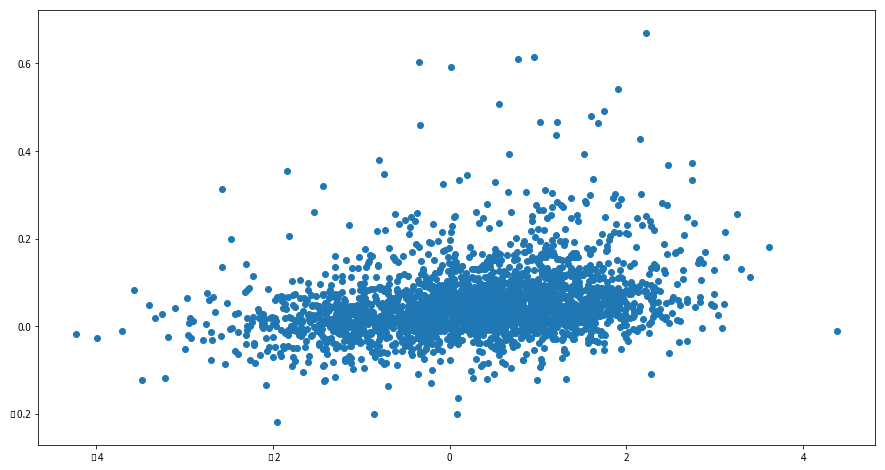

In [9]:
import statsmodels.api as sm
from statsmodels import regression   

data_factor = {}
for date in dateList:
    stockList = get_stock_A(date)
    df_market= get_price('000001.XSHG', count = 20*2, end_date=date, frequency='120m', fields=['open','close'])
    market_pchg = df_market['close']/df_market['open']-1
    # 加入一列常数列，表示市场的状态以及因子以外没有考虑到的因素
    X = sm.add_constant(market_pchg)
    # 进行多元线性回归
    results = regression.linear_model.OLS(factor_data[date], X).fit()
    # 返回多元线性回归的参数值    
    stock_resid = results.resid   
    temp_am = stock_resid.iloc[range(0,len(stock_resid),2)]
    temp_pm = stock_resid.iloc[range(1,len(stock_resid),2)]
    temp_am.index = [i.date() for i in temp_am.index]
    temp_pm.index = [i.date() for i in temp_pm.index]
    temp = temp_am - temp_pm
    stat = mean(temp) / (std(temp)/sqrt(len(temp)))
    df_stock = get_price(stockList, count = 21, end_date=date, frequency='1d', fields=['close'])['close']
    ret_20 = df_stock.iloc[-1] / df_stock.iloc[0] - 1
    temp = pd.DataFrame()
    temp['stat'] = stat
    temp['ret_20'] = ret_20
    data_factor[date] = temp
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,8))
plt.scatter(data_factor['2016-08-31']['stat'], data_factor['2016-08-31']['ret_20'])

    

上图以 2016 年 8 月底计算的因子为例，给出了所有股票的统计量 stat 与动量因子（20 日收益）的散点图，横轴为 stat 值，纵轴为股票过去 20 日的收益率。由图可以看出，散点比较集中，可近似得拟合出一条直线，可见统计量 stat 与动量因子存在强相关的关系。为了进一步分析统计量 stat 与动量因子的相关性，下文对其进行具体分析。


### 2.1.2 统计量 stat 与动量因子的相关系数

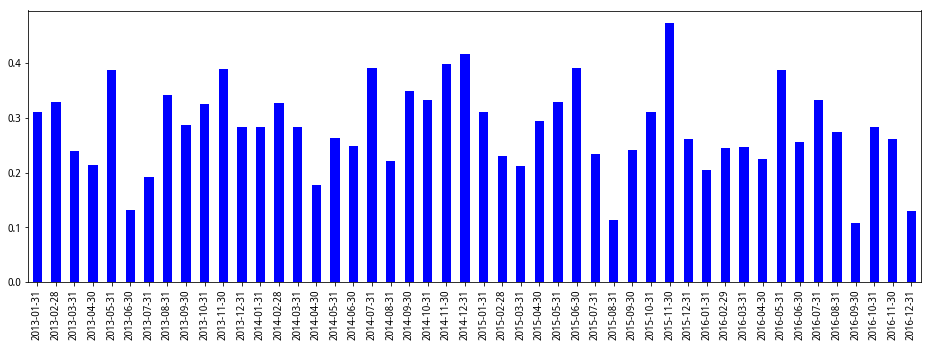

In [22]:
import matplotlib.dates as mdates

data_corr = []
for date in dateList[1:]:
    data_corr.append(data_factor[date].corr().iloc[0,1])
fig = plt.figure(figsize=(15,8))
corr_value = pd.DataFrame(index = dateList[1:])
corr_value['value'] = data_corr
corr_value['value'].plot('bar',figsize=(16,5))


上图给出了统计量 stat 与动量因子的逐月的相关系数，在 2013-2017 这 48 个月中，所有月份的相关系数超过 0.1，有 42 个月的相关系数超过 0.2，由此可见，统计量 stat 与动量因子之间相关性在大部分的时间都比较高，两个因子之间具有强相关性。


## 2.2 APM 因子的数值分布

### 2.2.1 APM 因子构建

为了消除与动量因子的纠缠，我们将统计量 stat 对动量因子进行横截面回归：  
<center>$stat = bRet20 + \epsilon$ </center>
其中，Ret20 为股票过去 20 日的收益率，代表动量因子。我们将回归得到的残差值 ε 作为最终的选股因子，命名为 APM 因子。  


In [26]:
from statsmodels.formula.api import ols
from jqfactor import winsorize_med
from jqfactor import standardlize

apm = {}
for date in dateList:
    # 数据中位数去极值
    temp = ols('ret_20~stat', data_factor[date]).fit()
    temp_apm = pd.DataFrame()
    temp_apm['factor'] = temp.resid
    temp_apm = temp_apm.sort('factor', ascending = True)
    apm[date] = temp_apm
content = pickle.dumps(apm) 
write_file('apm.pkl', content, append=False)


### 2.2.2 APM 因子 RankIC 的月度序列

在每个月的最后一个交易日，我们取所有股票最近 20 个交易日的行情数据，计算每只股票的 APM 因子。下图给出了每个月因子值与次月收益的秩相关系数 (RankIC)，因子的 IC 值一般是指个股第 T 期在因子上的暴露度与 T+1 期的收益率的相关系数，RankIC 指因子的排序结果与 T+1 期的排序结果的相关系数。

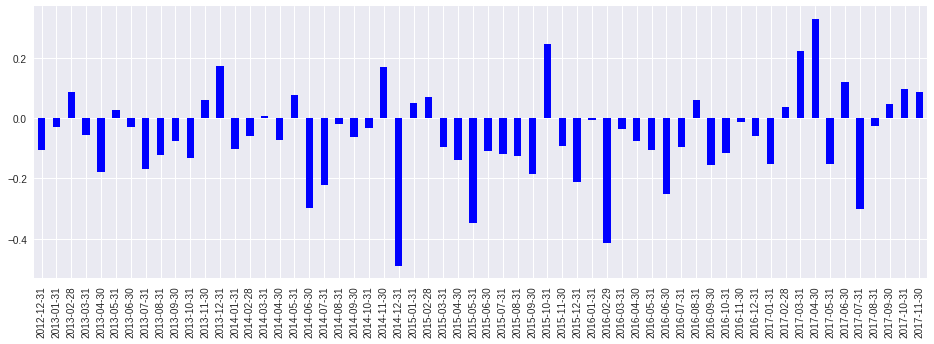

In [32]:
#因子IC分析
import scipy.stats as st

def factor_IC_analysis(rule='rank'):  
    IC = {}
    R_T = pd.DataFrame()
    for date in dateList[:-1]:
        stockList = list(apm[date].index)
        #获取横截面收益率
        df_close=get_price(stockList, date, dateList[dateList.index(date)+1], 'daily', ['close'])
        if df_close.empty:
            continue
        df_pchg=df_close['close'].iloc[-1,:]/df_close['close'].iloc[0,:]-1
        R_T['pchg'] = df_pchg
        R_T['factor'] = apm[date]['factor']
        R_T = R_T.dropna()
        if rule == 'normal':
            IC[date] = st.pearsonr(R_T.pchg, R_T['factor'])[0]
        elif rule == 'rank':
            IC[date] = st.pearsonr(R_T.pchg.rank(), R_T['factor'].rank())[0]
    IC = pd.Series(IC)
    IC.plot('bar',figsize=(16,5))
factor_IC_analysis()


由上图可以看出，在 2013-2018 年共 5 年 60 个月中，显著为正的有 18 个月，显著为负的有 42 个月。总体上倾向于负相关，即: 当月因子值越小，次月收益的期望值越高。形象地讲，APM 因子的数值越小，意味着知情交易者越倾向于做多; 反之，APM 因子的数值越大，则表示知情交易者越倾向于做空。  
为了在策略环境中更方便地调用数据，在每个截面期对 APM 因子按照从小到大的顺序进行排序，将结果保存在 apm.pkl 文件中。

# 3 策略构建

本节重点考察 APM 因子的选股能力，即通过计算股票 APM 因子值，实现对股票的筛选。  
全市场成份股：剔除 ST、停牌、上市时间 <3 个月的股票  
回测时间：2013-01-01 至 2017-01-01  
调仓期：每月第一个交易日  
选股：  
（1）每个月第一个交易日计算 APM 因子值   
（2）对 APM 因子值根据从小到大的顺序进行排序，并将其等分为 5 组  
（3）每个调仓日对每组股票池进行调仓交易，从而获得 5 组股票组合的收益曲线   
评价方法: 回测年化收益率、夏普比率、最大回撤、胜率等。  
回测年化收益率: 年化收益率通常指投资一年后能够获得的收益率，由于回测时间的长短，往往会由于复利的影响导致长时间的总收益率更大，此时可通过年化收益率衡量模型的收益能力。   
夏普比率: 目的是计算投资组合每承受一单位总风险，会产生多少的超额报酬。  
最大回撤: 最大回撤是指模型在过去的某一段时间可能出现的最大亏损程度，通常用来衡量模型的风险。在实际投资中，若是出现最大回撤较大的情况，往往会导致投资者对模型丧失信心，因此合理控制模型的最大回撤显得尤为重要。


In [29]:
#1 先导入所需要的程序包
import datetime
import numpy as np 
import pandas as pd
import time
from jqdata import *
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import copy
import pickle

# 定义类'参数分析'
class parameter_analysis(object):
    
    # 定义函数中不同的变量
    def __init__(self, algorithm_id=None):
        self.algorithm_id = algorithm_id            # 回测id
        
        self.params_df = pd.DataFrame()             # 回测中所有调参备选值的内容，列名字为对应修改面两名称，对应回测中的 g.XXXX
        self.results = {}                           # 回测结果的回报率，key 为 params_df 的行序号，value 为
        self.evaluations = {}                       # 回测结果的各项指标，key 为 params_df 的行序号，value 为一个 dataframe
        self.backtest_ids = {}                      # 回测结果的 id
        
        # 新加入的基准的回测结果 id，可以默认为空 ''，则使用回测中设定的基准
        self.benchmark_id = 'ae0684d86e9e7128b1ab9c7d77893029'                      
        
        self.benchmark_returns = []                 # 新加入的基准的回测回报率
        self.returns = {}                           # 记录所有回报率
        self.excess_returns = {}                    # 记录超额收益率
        self.log_returns = {}                       # 记录收益率的 log 值
        self.log_excess_returns = {}                # 记录超额收益的 log 值
        self.dates = []                             # 回测对应的所有日期
        self.excess_max_drawdown = {}               # 计算超额收益的最大回撤
        self.excess_annual_return = {}              # 计算超额收益率的年化指标
        self.evaluations_df = pd.DataFrame()        # 记录各项回测指标，除日回报率外
    
    # 定义排队运行多参数回测函数
    def run_backtest(self,                          #
                     algorithm_id=None,             # 回测策略id
                     running_max=10,                # 回测中同时巡行最大回测数量
                     start_date='2006-01-01',       # 回测的起始日期
                     end_date='2016-11-30',         # 回测的结束日期
                     frequency='day',               # 回测的运行频率
                     initial_cash='1000000',        # 回测的初始持仓金额
                     param_names=[],                # 回测中调整参数涉及的变量
                     param_values=[]                # 回测中每个变量的备选参数值
                     ):
        # 当此处回测策略的 id 没有给出时，调用类输入的策略 id
        if algorithm_id == None: algorithm_id=self.algorithm_id
        
        # 生成所有参数组合并加载到 df 中
        # 包含了不同参数具体备选值的排列组合中一组参数的 tuple 的 list
        param_combinations = list(itertools.product(*param_values))
        # 生成一个 dataframe， 对应的列为每个调参的变量，每个值为调参对应的备选值
        to_run_df = pd.DataFrame(param_combinations)
        # 修改列名称为调参变量的名字
        to_run_df.columns = param_names
        
        # 设定运行起始时间和保存格式
        start = time.time()
        # 记录结束的运行回测
        finished_backtests = {}
        # 记录运行中的回测
        running_backtests = {}
        # 计数器
        pointer = 0
        # 总运行回测数目，等于排列组合中的元素个数
        total_backtest_num = len(param_combinations)
        # 记录回测结果的回报率
        all_results = {}
        # 记录回测结果的各项指标
        all_evaluations = {}
        
        # 在运行开始时显示
        print '【已完成|运行中|待运行】:', 
        # 当运行回测开始后，如果没有全部运行完全的话：
        while len(finished_backtests)<total_backtest_num:
            # 显示运行、完成和待运行的回测个数
            print('[%s|%s|%s].' % (len(finished_backtests), 
                                   len(running_backtests), 
                                   (total_backtest_num-len(finished_backtests)-len(running_backtests)) )),
            # 记录当前运行中的空位数量
            to_run = min(running_max-len(running_backtests), total_backtest_num-len(running_backtests)-len(finished_backtests))
            # 把可用的空位进行跑回测
            for i in range(pointer, pointer+to_run):
                # 备选的参数排列组合的 df 中第 i 行变成 dict，每个 key 为列名字，value 为 df 中对应的值
                params = to_run_df.ix[i].to_dict()
                # 记录策略回测结果的 id，调整参数 extras 使用 params 的内容
                backtest = create_backtest(algorithm_id = algorithm_id,
                                           start_date = start_date, 
                                           end_date = end_date, 
                                           frequency = frequency, 
                                           initial_cash = initial_cash, 
                                           extras = params, 
                                           # 再回测中把改参数的结果起一个名字，包含了所有涉及的变量参数值
                                           name = str(params)
                                           )
                # 记录运行中 i 回测的回测 id
                running_backtests[i] = backtest
            # 计数器计数运行完的数量    
            pointer = pointer+to_run
            
            # 获取回测结果
            failed = []
            finished = []
            # 对于运行中的回测，key 为 to_run_df 中所有排列组合中的序数
            for key in running_backtests.keys():
                # 研究调用回测的结果，running_backtests[key] 为运行中保存的结果 id
                bt = get_backtest(running_backtests[key])
                # 获得运行回测结果的状态，成功和失败都需要运行结束后返回，如果没有返回则运行没有结束
                status = bt.get_status()
                # 当运行回测失败
                if status == 'failed':
                    # 失败 list 中记录对应的回测结果 id
                    failed.append(key)
                # 当运行回测成功时
                elif status == 'done':
                    # 成功 list 记录对应的回测结果 id，finish 仅记录运行成功的
                    finished.append(key)
                    # 回测回报率记录对应回测的回报率 dict， key to_run_df 中所有排列组合中的序数， value 为回报率的 dict
                    # 每个 value 一个 list 每个对象为一个包含时间、日回报率和基准回报率的 dict
                    all_results[key] = bt.get_results()
                    # 回测回报率记录对应回测结果指标 dict， key to_run_df 中所有排列组合中的序数， value 为回测结果指标的 dataframe
                    all_evaluations[key] = bt.get_risk()
            # 记录运行中回测结果 id 的 list 中删除失败的运行
            for key in failed:
                running_backtests.pop(key)
            # 在结束回测结果 dict 中记录运行成功的回测结果 id，同时在运行中的记录中删除该回测
            for key in finished:
                finished_backtests[key] = running_backtests.pop(key)
            # 当一组同时运行的回测结束时报告时间
            if len(finished_backtests) != 0 and len(finished_backtests) % running_max == 0 and to_run !=0:
                # 记录当时时间
                middle = time.time()
                # 计算剩余时间，假设没工作量时间相等的话
                remain_time = (middle - start) * (total_backtest_num - len(finished_backtests)) / len(finished_backtests)
                # print 当前运行时间
                print('[已用%s时,尚余%s时,请不要关闭浏览器].' % (str(round((middle - start) / 60.0 / 60.0,3)), 
                                          str(round(remain_time / 60.0 / 60.0,3)))),
            # 5秒钟后再跑一下
            time.sleep(5) 
        # 记录结束时间
        end = time.time() 
        print ''
        print('【回测完成】总用时：%s秒(即%s小时)。' % (str(int(end-start)), 
                                           str(round((end-start)/60.0/60.0,2)))),
        # 对应修改类内部对应
        self.params_df = to_run_df
        self.results = all_results
        self.evaluations = all_evaluations
        self.backtest_ids = finished_backtests

        
    #7 最大回撤计算方法
    def find_max_drawdown(self, returns):
        # 定义最大回撤的变量
        result = 0
        # 记录最高的回报率点
        historical_return = 0
        # 遍历所有日期
        for i in range(len(returns)):
            # 最高回报率记录
            historical_return = max(historical_return, returns[i])
            # 最大回撤记录
            drawdown = 1-(returns[i] + 1) / (historical_return + 1)
            # 记录最大回撤
            result = max(drawdown, result)
        # 返回最大回撤值
        return result

    # log 收益、新基准下超额收益和相对与新基准的最大回撤
    def organize_backtest_results(self, benchmark_id=None):
        # 若新基准的回测结果 id 没给出
        if benchmark_id==None:
            # 使用默认的基准回报率，默认的基准在回测策略中设定
            self.benchmark_returns = [x['benchmark_returns'] for x in self.results[0]]
        # 当新基准指标给出后    
        else:
            # 基准使用新加入的基准回测结果
            self.benchmark_returns = [x['returns'] for x in get_backtest(benchmark_id).get_results()]
        # 回测日期为结果中记录的第一项对应的日期
        self.dates = [x['time'] for x in self.results[0]]
        
        # 对应每个回测在所有备选回测中的顺序 （key），生成新数据
        # 由 {key：{u'benchmark_returns': 0.022480100091729405,
        #           u'returns': 0.03184566700000002,
        #           u'time': u'2006-02-14'}} 格式转化为：
        # {key: []} 格式，其中 list 为对应 date 的一个回报率 list
        for key in self.results.keys():
            self.returns[key] = [x['returns'] for x in self.results[key]]
        # 生成对于基准（或新基准）的超额收益率
        for key in self.results.keys():
            self.excess_returns[key] = [(x+1)/(y+1)-1 for (x,y) in zip(self.returns[key], self.benchmark_returns)]
        # 生成 log 形式的收益率
        for key in self.results.keys():
            self.log_returns[key] = [log(x+1) for x in self.returns[key]]
        # 生成超额收益率的 log 形式
        for key in self.results.keys():
            self.log_excess_returns[key] = [log(x+1) for x in self.excess_returns[key]]
        # 生成超额收益率的最大回撤
        for key in self.results.keys():
            self.excess_max_drawdown[key] = self.find_max_drawdown(self.excess_returns[key])
        # 生成年化超额收益率
        for key in self.results.keys():
            self.excess_annual_return[key] = (self.excess_returns[key][-1]+1)**(252./float(len(self.dates)))-1
        # 把调参数据中的参数组合 df 与对应结果的 df 进行合并
        self.evaluations_df = pd.concat([self.params_df, pd.DataFrame(self.evaluations).T], axis=1)
#         self.evaluations_df = 

    # 获取最总分析数据，调用排队回测函数和数据整理的函数    
    def get_backtest_data(self,
                          algorithm_id=None,                         # 回测策略id
                          benchmark_id=None,                         # 新基准回测结果id
                          file_name='results.pkl',                   # 保存结果的 pickle 文件名字
                          running_max=10,                            # 最大同时运行回测数量
                          start_date='2006-01-01',                   # 回测开始时间
                          end_date='2016-11-30',                     # 回测结束日期
                          frequency='day',                           # 回测的运行频率
                          initial_cash='1000000',                    # 回测初始持仓资金
                          param_names=[],                            # 回测需要测试的变量
                          param_values=[]                            # 对应每个变量的备选参数
                          ):
        # 调运排队回测函数，传递对应参数
        self.run_backtest(algorithm_id=algorithm_id,
                          running_max=running_max,
                          start_date=start_date,
                          end_date=end_date,
                          frequency=frequency,
                          initial_cash=initial_cash,
                          param_names=param_names,
                          param_values=param_values
                          )
        # 回测结果指标中加入 log 收益率和超额收益率等指标
        self.organize_backtest_results(benchmark_id)
        # 生成 dict 保存所有结果。
        results = {'returns':self.returns,
                   'excess_returns':self.excess_returns,
                   'log_returns':self.log_returns,
                   'log_excess_returns':self.log_excess_returns,
                   'dates':self.dates,
                   'benchmark_returns':self.benchmark_returns,
                   'evaluations':self.evaluations,
                   'params_df':self.params_df,
                   'backtest_ids':self.backtest_ids,
                   'excess_max_drawdown':self.excess_max_drawdown,
                   'excess_annual_return':self.excess_annual_return,
                   'evaluations_df':self.evaluations_df}
        # 保存 pickle 文件
        pickle_file = open(file_name, 'wb')
        pickle.dump(results, pickle_file)
        pickle_file.close()

    # 读取保存的 pickle 文件，赋予类中的对象名对应的保存内容    
    def read_backtest_data(self, file_name='results.pkl'):
        pickle_file = open(file_name, 'rb')
        results = pickle.load(pickle_file)
        self.returns = results['returns']
        self.excess_returns = results['excess_returns']
        self.log_returns = results['log_returns']
        self.log_excess_returns = results['log_excess_returns']
        self.dates = results['dates']
        self.benchmark_returns = results['benchmark_returns']
        self.evaluations = results['evaluations']
        self.params_df = results['params_df']
        self.backtest_ids = results['backtest_ids']
        self.excess_max_drawdown = results['excess_max_drawdown']
        self.excess_annual_return = results['excess_annual_return']
        self.evaluations_df = results['evaluations_df']
        
    # 回报率折线图    
    def plot_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.returns[key])), self.returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), self.benchmark_returns, label='benchmark', c='k', linestyle='--') 
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.returns[0]))
    
    # 多空组合图
    def plot_long_short(self):
       # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        a1 = [i+1 for i in self.returns[0]]
        a2 = [i+1 for i in self.returns[4]]
        a1.insert(0,1)   
        a2.insert(0,1)
        b = []
        for i in range(len(a1)-1):
            b.append((a1[i+1]/a1[i]-a2[i+1]/a2[i])/2)
        c = []
        c.append(1)
        for i in range(len(b)):
            c.append(c[i]*(1+b[i]))
        ax.plot(range(len(c)), c)
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        ax.set_title("Strategy's long_short performances",fontsize=20)
        # 设置图片标题样式
        plt.xlim(0, len(c))     
        return c
        
    # 获取不同年份的收益及排名分析
    def get_profit_year(self):
        profit_year = {}
        for key in self.returns.keys():
            temp = []
            date_year = []
            for i in range(len(self.dates)-1):
                if self.dates[i][:4] != self.dates[i+1][:4]:
                    temp.append(self.returns[key][i])
                    date_year.append(self.dates[i][:4])
            temp.append(self.returns[key][-1])
            date_year.append(self.dates[-1][:4]) 
            temp1 = []
            temp1.append(temp[0])
            for i in range(len(temp)-1):
                temp1.append((temp[i+1]+1)/(temp[i]+1)-1)
            profit_year[key] = temp1
        result = pd.DataFrame(index = list(self.returns.keys()), columns = date_year)
        for key in self.returns.keys():
            result.loc[key,:] = profit_year[key]
        return result
            
    # 超额收益率图    
    def plot_excess_returns(self):
        
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.excess_returns[key])), self.excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('excess returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.excess_returns[0]))
        
    # log回报率图    
    def plot_log_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_returns[key])), self.log_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [log(x+1) for x in self.benchmark_returns], label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_returns[0]))
    
    # 超额收益率的 log 图
    def plot_log_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_excess_returns[key])), self.log_excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log excess returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_excess_returns[0]))

        
    # 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
    def get_eval4_bar(self, sort_by=[]): 
        
        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        fig = plt.figure(figsize=(20,7))

        # 定义位置
        ax1 = fig.add_subplot(221)
        # 设定横轴为对应分位，纵轴为对应指标
        ax1.bar(range(len(indices)), 
                [self.evaluations[x]['algorithm_return'] for x in indices], 0.6, label = 'Algorithm_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax1.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax1.set_ylabel('Algorithm_return', fontsize=15)
        # 设置y标签样式
        ax1.set_yticklabels([str(x*100)+'% 'for x in ax1.get_yticks()])
        # 设置图片标题样式
        ax1.set_title("Strategy's of Algorithm_return performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax2 = fig.add_subplot(224)
        # 设定横轴为对应分位，纵轴为对应指标
        ax2.bar(range(len(indices)), 
                [self.evaluations[x]['max_drawdown'] for x in indices], 0.6, label = 'Max_drawdown')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax2.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax2.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax2.set_yticklabels([str(x*100)+'% 'for x in ax2.get_yticks()])
        # 设置图片标题样式
        ax2.set_title("Strategy's of Max_drawdown performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))
        # 定义位置
        ax3 = fig.add_subplot(223)
        # 设定横轴为对应分位，纵轴为对应指标
        ax3.bar(range(len(indices)),
                [self.evaluations[x]['sharpe'] for x in indices], 0.6, label = 'Sharpe')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax3.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax3.set_ylabel('Sharpe', fontsize=15)
        # 设置x标签样式
        ax3.set_yticklabels([str(x*100)+'% 'for x in ax3.get_yticks()])
        # 设置图片标题样式
        ax3.set_title("Strategy's of Sharpe performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax4 = fig.add_subplot(222)
        # 设定横轴为对应分位，纵轴为对应指标
        ax4.bar(range(len(indices)), 
                [self.evaluations[x]['algorithm_volatility'] for x in indices], 0.6, label = 'Algorithm_volatility')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax4.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax4.set_ylabel('Algorithm_volatility', fontsize=15)
        # 设置x标签样式
        ax4.set_yticklabels([str(x*100)+'% 'for x in ax4.get_yticks()])
        # 设置图片标题样式
        ax4.set_title("Strategy's of Algorithm_volatility performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))
        
    #14 年化回报和最大回撤，正负双色表示
    def get_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.evaluations[x]['max_drawdown'] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Max_drawdown', zorder=10)
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.evaluations[x]['annual_algo_return'] for x in indices], color = 'r', 
                     width = 0.6, label = 'Annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))

    #14 超额收益的年化回报和最大回撤
    # 加入新的benchmark后超额收益和
    def get_excess_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.excess_max_drawdown[x] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Excess_max_drawdown')
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.excess_annual_return[x] for x in indices], color = 'r', 
                     width = 0.6, label = 'Excess_annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))




In [30]:
def group_backtest(start_date,end_date,num):
    warnings.filterwarnings("ignore")
    pa = parameter_analysis()
    pa.get_backtest_data(file_name = 'results.pkl',
                          running_max = 10,
                          algorithm_id = 'f911e4638cdd36f9481ed3cd84a33735',
                          start_date=start_date,
                          end_date=end_date,
                          frequency = 'day',
                          initial_cash = '10000000',
                          param_names = ['num'],
                          param_values = [num]                     
                          )
start_date = '2013-01-01' 
end_date = '2017-01-01' 
num = range(1,6)
group_backtest(start_date,end_date,num)


【已完成|运行中|待运行】: [0|0|5]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [2|3|0]. [2|3|0]. [3|2|0]. [3|2|0]. [3|2|0]. [3|2|0]. [4|1|0]. [4|1|0]. [4|1|0]. [4|1|0]. [4|1|0]. [4|1|0]. [4|1|0]. [4|1

## 3.1 分层回测策略模型收益指标


In [31]:
pa = parameter_analysis()
pa.read_backtest_data('results.pkl')
pa.evaluations_df


,num,__version,algorithm_return,algorithm_volatility,alpha,annual_algo_return,annual_bm_return,benchmark_return,benchmark_volatility,beta,excess_return,information,max_drawdown,max_drawdown_period,max_leverage,period_label,sharpe,sortino,trading_days,treasury_return
0,1,101,2.113947,0.3216257,0.2690459,0.339711,0.07241527,0.311988,0.2689038,0.9460094,1.954386,1.354514,0.4665423,"[2015-06-12, 2015-09-15]",0,2016-12,0.9318629,1.050446,971,0.1595616
1,2,101,2.160743,0.3093458,0.2746688,0.3448659,0.07241527,0.311988,0.2689038,0.9315729,2.001182,1.493438,0.474468,"[2015-06-12, 2015-09-15]",0,2016-12,0.9855183,1.096296,971,0.1595616
2,3,101,1.880049,0.3060218,0.2430617,0.3130465,0.07241527,0.311988,0.2689038,0.9250205,1.720488,1.341329,0.498576,"[2015-06-12, 2015-09-15]",0,2016-12,0.8922453,0.9949378,971,0.1595616
3,4,101,1.396659,0.3068731,0.1824412,0.2523794,0.07241527,0.311988,0.2689038,0.9235837,1.237098,0.9919771,0.515841,"[2015-06-12, 2015-09-15]",0,2016-12,0.6920756,0.7754646,971,0.1595616
4,5,101,0.4952742,0.3115328,0.04001465,0.1091359,0.07241527,0.311988,0.2689038,0.898381,0.3357125,0.1849034,0.5622793,"[2015-06-12, 2016-01-28]",0,2016-12,0.2219217,0.2615389,971,0.1595616


## 3.2 分层回测净值

为了进一步更直观的对 5 个组合进行分析，绘制了 5 个组合及 HS300 基准的净值收益曲线，具体下图所示。  

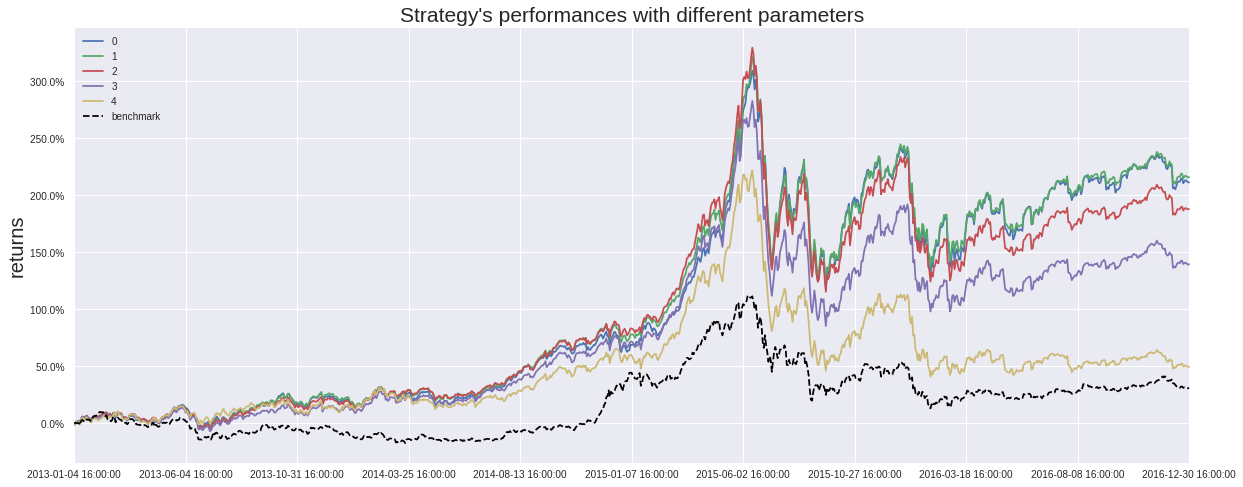

In [32]:
pa.plot_returns()


由图可以看出，组合 1 能够明显跑赢组合 5，且每个组合都能够跑赢 HS300 指数，且组合 1 能够吗明显获得更高的收益。可见符合单因子有效性的检验，即证明 APM 因子是有效的。

## 3.3 模型策略组合回测分析表

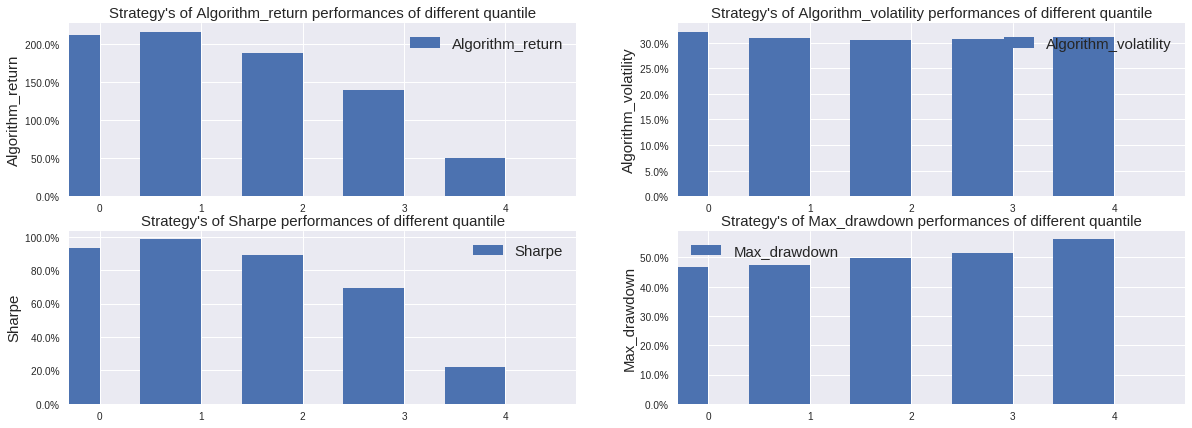

In [33]:
pa.get_eval4_bar()

上面几张表分析了每个投资组合的评价指标，根据年化收益、年化波动率、夏普比率及最大回撤分析，组合 1 的效果要远远好于组合 5，且基本上满足随着组合数的递增，收益能力下降且风险控制能力下降的趋势，由此符合单因子有效性的检验。

## 3.4 多空组合净值

从分层组合回测净值曲线图来看，每个组合波动性较大，策略存在较大的风险，因此考虑建立多空组合。多空组合是买入组合 1、卖空组合 5 (月度调仓)的一个资产组合，为了方便统计，多空组合每日收益率为（组合 1 每日收益率 - 组合 5 每日收益率）/2，然后获得多空组合的净值收益曲线，如图所示，多空组合净值收益曲线明显比任何一个组合的波动性更低，能够获得更为稳定的收益，风险控制效果较好。

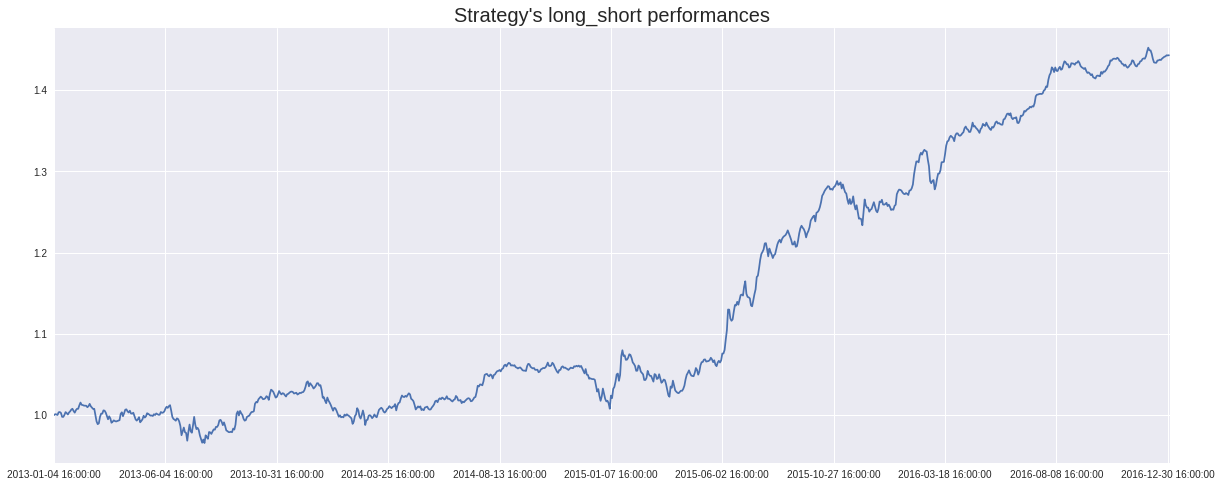

In [32]:
long_short = pa.plot_long_short()


下面给出了多空对冲净值的收益指标值，年化收益为 9.89%，期间最大回撤为 5.34%，夏普比率为 0.98，年化收益波动率为 5.98%。以上结果表明，APM 因子本身具有较强的选股能力。


In [55]:
def MaxDrawdown(return_list):
    '''最大回撤率'''
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  # 结束位置
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])  # 开始位置
    return (return_list[j] - return_list[i]) / (return_list[j])

def cal_indictor(long_short):
    total_return = long_short[-1] / long_short[0] - 1
    ann_return = pow((1+total_return), 250/float(len(long_short)))-1
    pchg = []
    #计算收益率
    for i in range(1, len(long_short)):
        pchg.append(long_short[i]/long_short[i-1] - 1)
    temp = 0
    for i in pchg:
        temp += pow(i-mean(pchg), 2)
    annualVolatility = sqrt(250/float((len(pchg)-1))*temp)
    sharpe_ratio = (ann_return - 0.04)/annualVolatility
    print "总收益: ", total_return
    print "年化收益: ", ann_return
    print "年化收益波动率: ", annualVolatility
    print "夏普比率: ",sharpe_ratio
    print "最大回测: ",MaxDrawdown(long_short)
cal_indictor(long_short)
    

总收益:  0.442755037908
年化收益:  0.0988656521956
年化收益波动率:  0.0598387615949
夏普比率:  0.983737808514
最大回测:  0.0533572244934


# 4 APM 因子的风险特征

本小节我们重点关注 APM 因子与常见因子的关联性。根据前文的定义方式，APM 因子与动量因子之间不相关。下面给出了按照 APM 因子排序分组后各组的市值百分位分布特征。

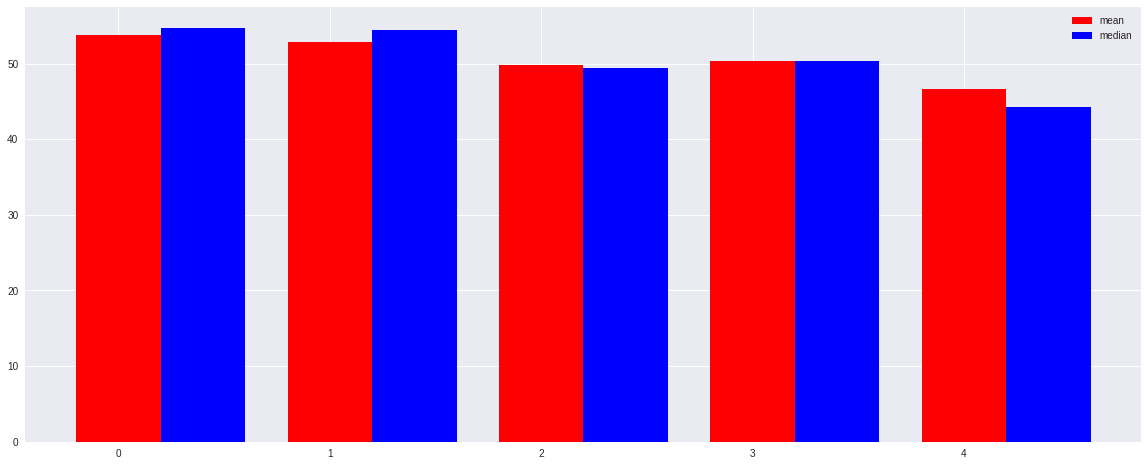

In [91]:
def get_median(data):
    data.sort()
    half = len(data) // 2
    return (data[half] + data[~half]) / 2

date = '2016-08-31'
stockList = get_stock_A(date)
q = query(valuation.code, valuation.market_cap).filter(valuation.code.in_(stockList))
df = get_fundamentals(q, date = date)
df = df.sort('market_cap', ascending = True)
temp_a = list(df['code'])
temp_mean = []
temp_median = []
for num in range(1,6):
    a = apm[date].index[len(apm[date])*(num-1)/5:len(apm[date])*num/5]
    temp = []
    for i in a:
        temp.append(temp_a.index(i) / float(len(df))*100)
    temp_mean.append(mean(temp))
    temp_median.append(get_median(temp))
width = 0.4
x =list(range(len(temp_mean)))
fig = plt.figure(figsize=(20,8))
plt.bar(x, temp_mean, width = width, label='mean',fc = 'r')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, temp_median, width = width, label='median',fc = 'b')
plt.legend()
plt.show()



由上图可以看出，组合 1 所筛选出来的股票组合市值百分位的均值及中位数均要小于其他组合，且从组合 1 到组合 5 来看，市值百分位均值及中位数均呈现“逐渐降低”的特点，由此可见该因子与市值密切相关。

## 4.1 策略构建

为了考察 APM 因子自身的收益特征，我们通过横截面回归取残差的方式，对市值、行业等因子进行剔除。横截面回归模型如下:
<center>$APM_i = \beta_1 LogMktVal_i + \sum_{j=1}^M \beta_{2j} Ind_{ji} + \epsilon_i$ </center>  
其中，LogMktVal 为股票的对数流通市值，Ind 为申万一级行业哑变量，ε 为残差因子。  
策略步骤：  
（1）根据公式，将 APM 因子值作为因变量，对数流通市值以及申万一级行业因子作为自变量，进行多元线性回归，将计算得到的残差数据作为新的因子  
（2）将新的因子按照从小到大的顺序排序，并将其等分为 5 组  
（3）每个调仓日对每组股票池进行调仓交易，从而获得 5 组股票组合的收益曲线  
评价方法: 回测年化收益率、夏普比率、最大回撤、胜率等。  


In [38]:
def group_backtest(start_date,end_date,num):
    warnings.filterwarnings("ignore")
    pa = parameter_analysis()
    pa.get_backtest_data(file_name = 'results_1.pkl',
                          running_max = 10,
                          algorithm_id = '570bb1397be69c63e49292a98eb5116b',
                          start_date=start_date,
                          end_date=end_date,
                          frequency = 'day',
                          initial_cash = '10000000',
                          param_names = ['num'],
                          param_values = [num]                     
                          )

start_date = '2013-01-01' 
end_date = '2017-01-01' 
num = range(1,6)
group_backtest(start_date,end_date,num)


【已完成|运行中|待运行】: [0|0|5]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [0|5|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [1|4|0]. [3|2|0]. [3|2|0]. [3|2

## 4.2 分层回测策略模型收益指标

In [56]:
pa = parameter_analysis()
pa.read_backtest_data('results_1.pkl')
pa.evaluations_df


,num,__version,algorithm_return,algorithm_volatility,alpha,annual_algo_return,annual_bm_return,benchmark_return,benchmark_volatility,beta,excess_return,information,max_drawdown,max_drawdown_period,max_leverage,period_label,sharpe,sortino,trading_days,treasury_return
0,1,101,2.331648,0.321739,0.2926142,0.3632241,0.07241512,0.3119872,0.2689038,0.9443079,2.172087,1.467669,0.4837919,"[2015-06-12, 2015-09-15]",0,2016-12,1.004616,1.128863,971,0.1595616
1,2,101,2.176119,0.3083798,0.2761774,0.3465474,0.07241512,0.3119872,0.2689038,0.9369083,2.016558,1.534531,0.4644429,"[2015-06-12, 2015-09-15]",0,2016-12,0.9940578,1.108911,971,0.1595616
2,3,101,1.824214,0.3050376,0.2361933,0.3064448,0.07241512,0.3119872,0.2689038,0.9332518,1.664653,1.342435,0.4963278,"[2015-06-12, 2015-09-15]",0,2016-12,0.8734817,0.9726974,971,0.1595616
3,4,101,1.294294,0.309345,0.1681391,0.2383832,0.07241512,0.3119872,0.2689038,0.9330225,1.134732,0.9126394,0.5261568,"[2015-06-12, 2015-09-15]",0,2016-12,0.6413008,0.7158328,971,0.1595616
4,5,101,0.4974321,0.3067568,0.0409352,0.1095478,0.07241512,0.3119872,0.2689038,0.8826932,0.3378704,0.1886216,0.5590566,"[2015-06-12, 2016-01-28]",0,2016-12,0.2267197,0.2650594,971,0.1595616


## 4.3 分层回测净值

为了进一步更直观的对 5 个组合进行分析，绘制了 5 个组合及 HS300 基准的净值收益曲线，具体下图所示。  

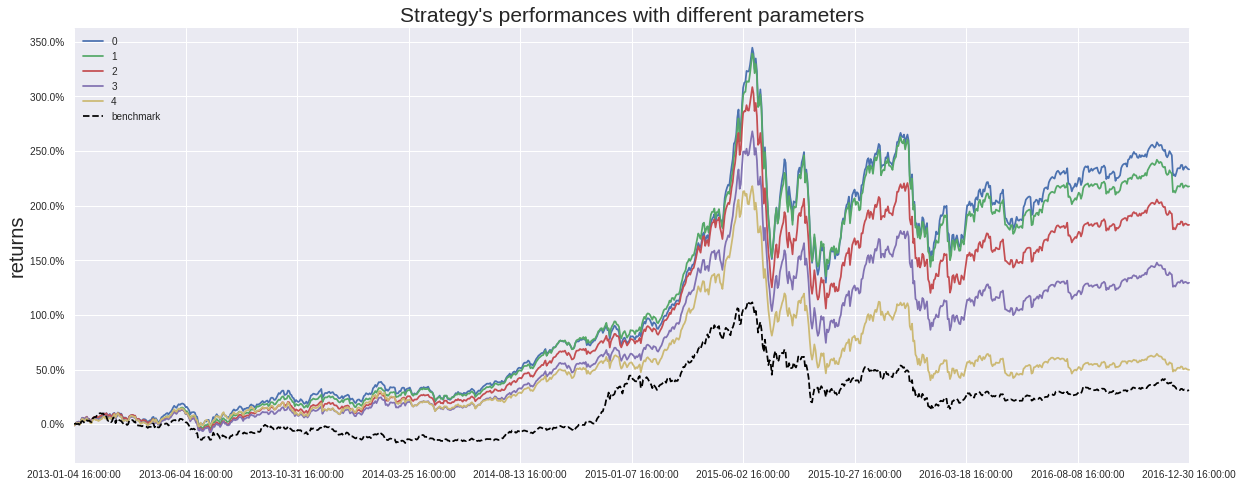

In [57]:
pa.plot_returns()


由图可以看出，组合 1 能够明显跑赢组合 5，且每个组合都能够跑赢 HS300 指数，且组合 1 能够吗明显获得更高的收益。可见符合单因子有效性的检验，即证明经过对数流通市值以及申万一级行业调整后的 APM 因子是有效的。

## 4.4 剔除市值因子、行业因子后的多空对冲收益

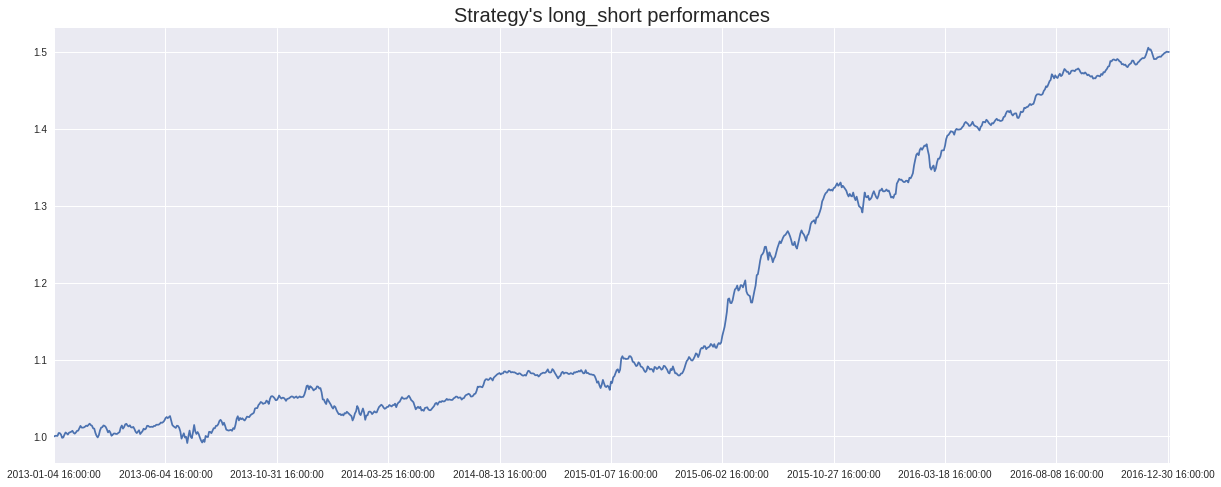

In [58]:
long_short = pa.plot_long_short()


下面给出了按照残差因子排序分五组的多空对冲净值，年化收益为 10.99%，期间最大回撤为 4.26%，夏普比率为 1.52，年化收益波动率为 4.59%。以上结果表明，经过对数流通市值以及申万一级行业调整后的 APM 因子本身具有较强的选股能力。


In [59]:
cal_indictor(long_short)

总收益:  0.49978907581
年化收益:  0.109878027327
年化收益波动率:  0.0458550477636
夏普比率:  1.52388953311
最大回测:  0.0425962097909


# 总结

以上我们对 APM 因子进行了有效性分析的具体测试，初步得到以下几个结论:  
（1）通过对日内上午收益率、下午收益率的分析，构建统计量 stat，分析发现该统计量与动量因子具有较强相关性，因此通过回归取残差的方法构建 APM 因子。  
（2）以 2013-2017 年为分析周期，研究了 APM 因子的有效性，通过 5 层分层回测及多空组合分析，其分层回测结果表明 5 个组合的收益曲线层次分明，组合 1 很明显能够跑赢其他组合及大盘，多空组合的年化收益为 9.89%，期间最大回撤为 5.34%，夏普比率为 0.98，年化收益波动率为 5.98%，可见 APM 因子在选股中具有较强的有效性。  
（3）分析发现 APM 因子与市值具有较强的相关性，因子对 APM 因子进行市值行业中性化处理，根据处理后的记过进行分层回测及多空组合，多空对冲组合的年化收益为 10.99%，期间最大回撤为 4.26%，夏普比率为 1.52，年化收益波动率为 4.59%，与原始 APM 因子相比不仅收益能力更强，且对风险的控制做的更好。  
（4）本文思路为因子有效性分析提供了一个很好地思路，也为日内高频数据分析提供了方向。

